# Retrieve task-related articles and sentences based on two-level of tf-idf
#### Goal
Given a large number of literature and queries of interest, retrieve the most relevant information to the queries from the literature. 
#### Approach
Since there is no ground-truth answer to each task, we model each task as an information retrieval problem and adopt the tf-idf features to quantize the similarity between queries of each task and articles. Specifically, we implement a two-level tf-idf information retrieval system. On the first level, the most relevant articles are retrieved for each task. On the second level, the most relevant sentences are retrieved from the articles retrieved on the first level. The articles/sentences are ranked based on cosine similarity between tf-idf feature vectors of articles/sentences and the target query. The same approach is applicable to all 10 tasks in this challenge. Once all the articles are vectorized and indexed, they can be reloaded to quickly respond to different queries of different tasks without re-training.

In [1]:
import numpy as np
import pandas as pd
import os
from os import listdir
from os.path import isfile, join
import collections
import re
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, PorterStemmer, SnowballStemmer, WordNetLemmatizer
import time
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.spatial.distance import cdist
import pickle
import json

# I. Metadata basic statistics
We first examine the metadata to gain a deeper understanding of the dataset. We pay more attention to the abstracts as an abstract is usually a high-level summary of the discovery of a study, thus it is information-enriched. In addition, while less than half of the articles have a full-text available, most articles have an abstract provided.

## 1. Read-in metadata

In [3]:
#metaDataPath = "/kaggle/input/CORD-19-research-challenge/2020-03-13/all_sources_metadata_2020-03-13.csv"
metaDataPath = "~/Downloads/2020-03-13/all_sources_metadata_2020-03-13.csv"
metaData = pd.read_csv(metaDataPath, header = 0)
print("The number of articles: " + str(metaData.shape[0]))
metaData.head()

The number of articles: 29500


,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_full_text
0,c630ebcdf30652f0422c3ec12a00b50241dc9bd9,CZI,Angiotensin-converting enzyme 2 (ACE2) as a SA...,10.1007/s00134-020-05985-9,NaN,32125455.0,cc-by-nc,NaN,2020,"Zhang, Haibo; Penninger, Josef M.; Li, Yimin; ...",Intensive Care Med,2.002765e+09,#3252,True
1,53eccda7977a31e3d0f565c884da036b1e85438e,CZI,Comparative genetic analysis of the novel coro...,10.1038/s41421-020-0147-1,NaN,NaN,cc-by,NaN,2020,"Cao, Yanan; Li, Lin; Feng, Zhimin; Wan, Shengq...",Cell Discovery,3.003431e+09,#1861,True
2,210a892deb1c61577f6fba58505fd65356ce6636,CZI,Incubation Period and Other Epidemiological Ch...,10.3390/jcm9020538,NaN,NaN,cc-by,The geographic spread of 2019 novel coronaviru...,2020,"Linton, M. Natalie; Kobayashi, Tetsuro; Yang, ...",Journal of Clinical Medicine,3.006065e+09,#1043,True
3,e3b40cc8e0e137c416b4a2273a4dca94ae8178cc,CZI,Characteristics of and Public Health Responses...,10.3390/jcm9020575,NaN,32093211.0,cc-by,"In December 2019, cases of unidentified pneumo...",2020,"Deng, Sheng-Qun; Peng, Hong-Juan",J Clin Med,1.776631e+08,#1999,True
4,92c2c9839304b4f2bc1276d41b1aa885d8b364fd,CZI,Imaging changes in severe COVID-19 pneumonia,10.1007/s00134-020-05976-w,NaN,32125453.0,cc-by-nc,NaN,2020,"Zhang, Wei",Intensive Care Med,3.006643e+09,#3242,False


## 2. Nan elements counts in all columns

In [4]:
metaData.isnull().sum()

sha                            12080
source_x                           0
title                            370
doi                             3143
pmcid                           2163
pubmed_id                      12770
license                        11808
abstract                        2947
publish_time                   11252
authors                          946
journal                        11709
Microsoft Academic Paper ID    28366
WHO #Covidence                 28264
has_full_text                  12080
dtype: int64

## 3. Literature source distribution

In [5]:
sourceDic = collections.defaultdict(int)
for s in metaData["source_x"][metaData["source_x"].notnull()]:
    sourceDic[s] += 1
sizes = []
explode = []
labels = []
for s in sourceDic:
    sizes.append(sourceDic[s])
    explode.append(0)
    labels.append(s)

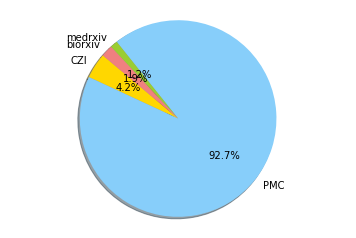

In [6]:
colors = ['gold', 'lightskyblue', 'yellowgreen', 'lightcoral']
plt.pie(sizes, explode=explode, labels=labels, colors = colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.show()

## 4. Publish year distribution

In [7]:
yearList = []
for y in metaData["publish_time"][metaData["publish_time"].notnull()]:
    yearList.append(int(re.split(' |-', y)[0]))

Text(0, 0.5, 'Frequency')

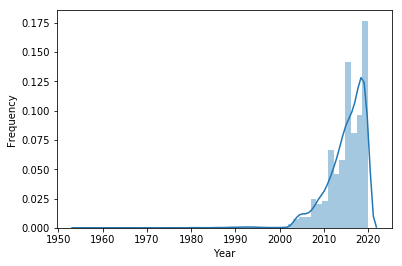

In [8]:
sns.distplot(yearList, bins = 50)
plt.xlabel("Year")
plt.ylabel("Frequency")

A lot more coronaviruses related articles published in the past 10 years.

## 5. Has full text distribution

In [9]:
hasFullText = metaData["has_full_text"][metaData["has_full_text"].notnull()]
nanCount = metaData.shape[0] - hasFullText.shape[0]
trueCount = sum(hasFullText)
falseCount = hasFullText.shape[0] - trueCount
print("The number of articles with full text: " + str(trueCount))
print("The number of articles without full text: " + str(falseCount + nanCount))

The number of articles with full text: 13219
The number of articles without full text: 16281


## 6. Abstract distribution

In [10]:
print("The number of articles with abstract: " + str(sum(metaData["abstract"].notnull())))

The number of articles with abstract: 26553


Now we try to normalize the abstracts to learn the distribution of abstract length and tokens. The following steps will also be the steps to preprocess the abstracts for extracting tf-idf features.

In [11]:
startTime = time.time()
absLength = []
word2count = {}
for abstract in metaData["abstract"][metaData["abstract"].notnull()]:
    ## Remove web links
    abstract = re.sub('https?://\S+|www\.\S+', '', abstract) 

    ## Lowercase
    abstract = abstract.lower()
    
    ## Remove punctuation
    abstract = re.sub('<.*?>+', ' ', abstract)
    abstract = re.sub('[%s]' % re.escape(string.punctuation), ' ', abstract)
    
    ## Remove number
    abstract = re.sub(r'\d+', '', abstract)
    
    ## Tokenize
    words = word_tokenize(abstract)
    
    ## Remove stop words
    nltk_stop_words = stopwords.words('english')
    words = [word for word in words if word not in nltk_stop_words]
    
    ## Stem
    stemmer = SnowballStemmer('english')
    words = [stemmer.stem(word) for word in words]
    
    ## Lematize verbs
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word, pos='v') for word in words]
    
    ## Record length
    absLength.append(len(words))
    
    ## Get word count
    for word in words:
        count = word2count.get(word, 0)
        word2count[word] = count + 1
print("Time spent: " + str(round((time.time() - startTime) / 60, 3)) + "min.")
print("The number of tokens: " + str(len(word2count)))

Time spent: 2.217min.
The number of tokens: 50493


### Distribution of abstract length
There are 20 extremely long abstracts. We excluded them from the histogram.

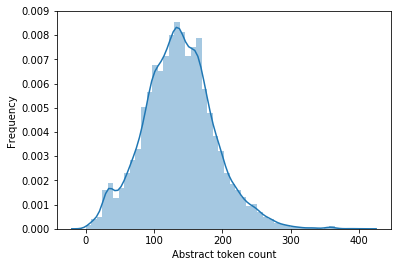

In [12]:
sns.distplot(sorted(absLength)[:-20], bins = 50) # There are 20 extremely long abstracts
plt.xlabel("Abstract token count")
plt.ylabel("Frequency")
plt.show()

### Top 50 mostly frequent tokens

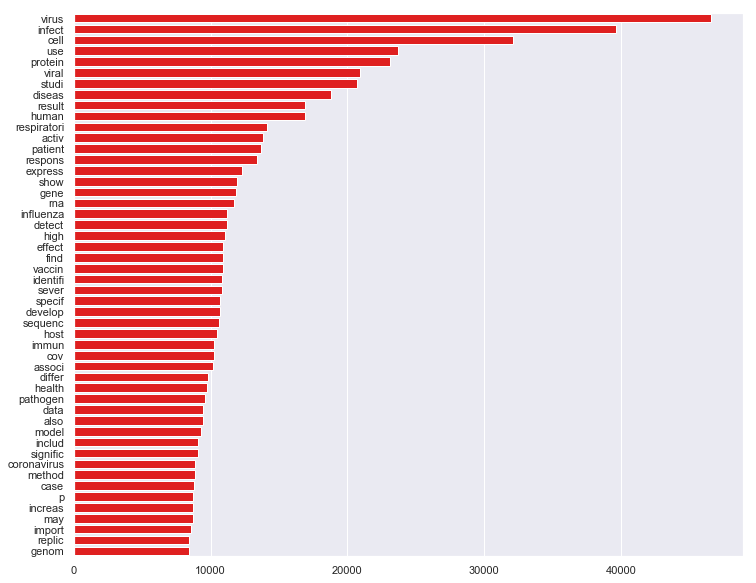

In [13]:
df_word_count = pd.DataFrame(sorted(word2count.items(), key=lambda x: x[1])[::-1])
sns.set(rc={'figure.figsize':(12,10)})
sns.barplot(y = df_word_count[0].values[:50], x = df_word_count[1].values[:50], color='red')

# II. Article and sentence retrieval
Now let's start to build the system for article and sentence retrieval.

## 1. Preprocess metadata
This section only needs to be run once. The new metadata table with the normalized abstracts in the column "clean_abstract" will be saved to all_sources_metadata_2020-03-13_clean.csv in the output folder.

In [14]:
def textNormalize(rawString):
    """
    Function for text normalization.
    Text normalization includes:
    1. removing web links
    2. converting all letters to lower or upper case
    3. removing punctuations
    4. removing numbers
    5. tokenization
    6. removing stopwords
    7. stemming
    8. lemmatization
    Input:
        rawString: a string contains the text to be normaized. 
    Output:
        normText: a string contains the normalized text where the tokens extracted from rawString are joined by space.
    """
    if rawString == np.nan:
        return rawString
    ## Remove web links
    rawString = re.sub('https?://\S+|www\.\S+', '', rawString) 

    ## Lowercase
    rawString = rawString.lower()
    
    ## Remove punctuation
    rawString = re.sub('<.*?>+', ' ', rawString)
    rawString = re.sub('[%s]' % re.escape(string.punctuation), ' ', rawString)
    
    ## Remove number
    rawString = re.sub(r'\d+', '', rawString)
    
    ## Tokenize
    words = word_tokenize(rawString)
    
    ## Remove stop words
    nltk_stop_words = stopwords.words('english')
    words = [word for word in words if word not in nltk_stop_words]
    
    ## Stem
    stemmer = SnowballStemmer('english')
    words = [stemmer.stem(word) for word in words]
    
    ## Lematize verbs
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word, pos='v') for word in words]
    
    normText = " ".join(words)
    
    return normText

### Read-in metadata

In [16]:
#metaDataPath = "/kaggle/input/CORD-19-research-challenge/2020-03-13/all_sources_metadata_2020-03-13.csv"
metaDataPath = "~/Downloads/2020-03-13/all_sources_metadata_2020-03-13.csv"
metaData = pd.read_csv(metaDataPath, header = 0)
print("The number of articles: " + str(metaData.shape[0]))
metaData.head()

The number of articles: 29500


,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_full_text
0,c630ebcdf30652f0422c3ec12a00b50241dc9bd9,CZI,Angiotensin-converting enzyme 2 (ACE2) as a SA...,10.1007/s00134-020-05985-9,NaN,32125455.0,cc-by-nc,NaN,2020,"Zhang, Haibo; Penninger, Josef M.; Li, Yimin; ...",Intensive Care Med,2.002765e+09,#3252,True
1,53eccda7977a31e3d0f565c884da036b1e85438e,CZI,Comparative genetic analysis of the novel coro...,10.1038/s41421-020-0147-1,NaN,NaN,cc-by,NaN,2020,"Cao, Yanan; Li, Lin; Feng, Zhimin; Wan, Shengq...",Cell Discovery,3.003431e+09,#1861,True
2,210a892deb1c61577f6fba58505fd65356ce6636,CZI,Incubation Period and Other Epidemiological Ch...,10.3390/jcm9020538,NaN,NaN,cc-by,The geographic spread of 2019 novel coronaviru...,2020,"Linton, M. Natalie; Kobayashi, Tetsuro; Yang, ...",Journal of Clinical Medicine,3.006065e+09,#1043,True
3,e3b40cc8e0e137c416b4a2273a4dca94ae8178cc,CZI,Characteristics of and Public Health Responses...,10.3390/jcm9020575,NaN,32093211.0,cc-by,"In December 2019, cases of unidentified pneumo...",2020,"Deng, Sheng-Qun; Peng, Hong-Juan",J Clin Med,1.776631e+08,#1999,True
4,92c2c9839304b4f2bc1276d41b1aa885d8b364fd,CZI,Imaging changes in severe COVID-19 pneumonia,10.1007/s00134-020-05976-w,NaN,32125453.0,cc-by-nc,NaN,2020,"Zhang, Wei",Intensive Care Med,3.006643e+09,#3242,False


### Normalize abstracts

In [4]:
startTime = time.time()
metaData["clean_abstract"] = float("NaN")
metaData.loc[metaData["abstract"].notnull(), "clean_abstract"] = \
metaData["abstract"][metaData["abstract"].notnull()].apply(lambda x: textNormalize(x))
print("Time spent: " + str(round((time.time() - startTime) / 60, 3)) + "min.")

Time spent: 2.231min.


### Output the new metadata table

In [5]:
metaData.to_csv("~/Downloads/2020-03-13/all_sources_metadata_2020-03-13_clean.csv")

## 2. Learn tf-idf vectorizer

This step only needs to be run once. A tf-idf vectorizer will be trained from the normalized abstracts and saved to tf-idf_vectorizer.pkl

### Read-in metadata with normalized abstracts

In [27]:
metaDataPath = "~/Downloads/2020-03-13/all_sources_metadata_2020-03-13_clean.csv"
metaData = pd.read_csv(metaDataPath, header = 0)
metaData.head()

,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_full_text,clean_abstract
0,c630ebcdf30652f0422c3ec12a00b50241dc9bd9,CZI,Angiotensin-converting enzyme 2 (ACE2) as a SA...,10.1007/s00134-020-05985-9,NaN,32125455.0,cc-by-nc,NaN,2020,"Zhang, Haibo; Penninger, Josef M.; Li, Yimin; ...",Intensive Care Med,2.002765e+09,#3252,True,NaN
1,53eccda7977a31e3d0f565c884da036b1e85438e,CZI,Comparative genetic analysis of the novel coro...,10.1038/s41421-020-0147-1,NaN,NaN,cc-by,NaN,2020,"Cao, Yanan; Li, Lin; Feng, Zhimin; Wan, Shengq...",Cell Discovery,3.003431e+09,#1861,True,NaN
2,210a892deb1c61577f6fba58505fd65356ce6636,CZI,Incubation Period and Other Epidemiological Ch...,10.3390/jcm9020538,NaN,NaN,cc-by,The geographic spread of 2019 novel coronaviru...,2020,"Linton, M. Natalie; Kobayashi, Tetsuro; Yang, ...",Journal of Clinical Medicine,3.006065e+09,#1043,True,geograph spread novel coronavirus covid infect...
3,e3b40cc8e0e137c416b4a2273a4dca94ae8178cc,CZI,Characteristics of and Public Health Responses...,10.3390/jcm9020575,NaN,32093211.0,cc-by,"In December 2019, cases of unidentified pneumo...",2020,"Deng, Sheng-Qun; Peng, Hong-Juan",J Clin Med,1.776631e+08,#1999,True,decemb case unidentifi pneumonia histori expos...
4,92c2c9839304b4f2bc1276d41b1aa885d8b364fd,CZI,Imaging changes in severe COVID-19 pneumonia,10.1007/s00134-020-05976-w,NaN,32125453.0,cc-by-nc,NaN,2020,"Zhang, Wei",Intensive Care Med,3.006643e+09,#3242,False,NaN


### Learn vocabulary and idf from training set

In [3]:
startTime = time.time()
vectorizer = TfidfVectorizer(tokenizer = word_tokenize)
vectorizer.fit(metaData["clean_abstract"][metaData["clean_abstract"].notnull()])
print('Time spent: ' + str(time.time() - startTime) + 's.')

Time spent: 20.281893014907837s.


### Save the learned vectorizer

In [4]:
vectPath = "../../../Downloads/2020-03-13/tf-idf_vectorizer.pkl"
with open(vectPath, "wb") as vectFile:
    pickle.dump(vectorizer, vectFile)

## 3. Retrieve literatures for each task

### Read-in metadata with normalized abstracts

In [2]:
metaDataPath = "~/Downloads/2020-03-13/all_sources_metadata_2020-03-13_clean.csv"
metaData = pd.read_csv(metaDataPath, header = 0)
metaData.head()

,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_full_text,clean_abstract
0,c630ebcdf30652f0422c3ec12a00b50241dc9bd9,CZI,Angiotensin-converting enzyme 2 (ACE2) as a SA...,10.1007/s00134-020-05985-9,NaN,32125455.0,cc-by-nc,NaN,2020,"Zhang, Haibo; Penninger, Josef M.; Li, Yimin; ...",Intensive Care Med,2.002765e+09,#3252,True,NaN
1,53eccda7977a31e3d0f565c884da036b1e85438e,CZI,Comparative genetic analysis of the novel coro...,10.1038/s41421-020-0147-1,NaN,NaN,cc-by,NaN,2020,"Cao, Yanan; Li, Lin; Feng, Zhimin; Wan, Shengq...",Cell Discovery,3.003431e+09,#1861,True,NaN
2,210a892deb1c61577f6fba58505fd65356ce6636,CZI,Incubation Period and Other Epidemiological Ch...,10.3390/jcm9020538,NaN,NaN,cc-by,The geographic spread of 2019 novel coronaviru...,2020,"Linton, M. Natalie; Kobayashi, Tetsuro; Yang, ...",Journal of Clinical Medicine,3.006065e+09,#1043,True,geograph spread novel coronavirus covid infect...
3,e3b40cc8e0e137c416b4a2273a4dca94ae8178cc,CZI,Characteristics of and Public Health Responses...,10.3390/jcm9020575,NaN,32093211.0,cc-by,"In December 2019, cases of unidentified pneumo...",2020,"Deng, Sheng-Qun; Peng, Hong-Juan",J Clin Med,1.776631e+08,#1999,True,decemb case unidentifi pneumonia histori expos...
4,92c2c9839304b4f2bc1276d41b1aa885d8b364fd,CZI,Imaging changes in severe COVID-19 pneumonia,10.1007/s00134-020-05976-w,NaN,32125453.0,cc-by-nc,NaN,2020,"Zhang, Wei",Intensive Care Med,3.006643e+09,#3242,False,NaN


### Load the tf-idf vectorizer

In [3]:
vectPath = "../../../Downloads/2020-03-13/tf-idf_vectorizer.pkl"
with open(vectPath, 'rb') as vectFile:
    vectorizer = pickle.load(vectFile)

### Transfer abstracts to document-term matrix

In [4]:
docTermMatrix = vectorizer.transform(metaData["clean_abstract"][metaData["clean_abstract"].notnull()]).toarray()

### Queries for tasks
Allow multiple queries for each task.
#### Task I: What is known about transmission, incubation, and environmental stability?

In [27]:
queries = ["What is known about transmission, incubation, and environmental stability?",
          "Range of incubation periods for the disease in humans (and how this varies \
          across age and health status) and how long individuals are contagious, even after recovery"] # Can be replaced with any queries related to the task

### Transfer queries to query-term matrix

In [28]:
normQueries = [textNormalize(q) for q in queries] # Text normalization for all queries
queryTermMatrix = vectorizer.transform(normQueries).toarray()

### Retrieve top related literatures based on cosine similarity

Compute cosine similarity between each query and all abstracts.

In [32]:
startTime = time.time()
queryDocDist = 1 - cdist(queryTermMatrix, docTermMatrix, metric = 'cosine')
print("Time spent: " + str(round((time.time() - startTime), 3)) + "s.")

Time spent: 38.5s.


List out the meta information for top n related literatures

In [30]:
def retrieveTopLiter(queries, queryDocDist, outputPath, nDoc = 5, showResults = True):
    """
    Function to retrieve the top n literatures for each query based on cosine similarities between query tf-idf 
    representations and literature tf-idf representations. 
    Input:
        queries: a list of m strings where each string is a text normalized query.
        queryDocDist: a m x n array that gives the pairwise cosine similarity between the m queries and n literatures.
        outputPath: a string specifies the path to the output file.
        nDoc (default 5): the number of literatures to be retrieved for each query.
        showResults (default True): whether show the results in the terminal.
    Output:
        The abstract and metadata of the retrieved literatures will be written to the output file specified by
        outputPath.
    """
    outputFile = open(outputPath, "w")
    for i in range(len(queries)):
        print("Query: ", queries[i])
        print("")
        outputFile.write("Query: " + queries[i] + "\n\n")
        docCount = 1
        for idx in queryDocDist[i].argsort()[-nDoc:][::-1]:
            literatureMeta = metaData[metaData["abstract"].notnull()].iloc[idx]
            if showResults:
                print("#" + str(docCount) + " literature")
                print("Cosine similarity: ", queryDocDist[i][idx])
                print("Title: ", literatureMeta["title"])
                print("Abstract: ", literatureMeta["abstract"])
                print("sha: ", literatureMeta["sha"])
                print("Has full text: ", literatureMeta["has_full_text"])
                print("")
            
            outputFile.write("#" + str(docCount) + " literature\n")
            outputFile.write("Cosine similarity: " + str(round(queryDocDist[i][idx], 5)) + "\n")
            outputFile.write("Title: " + literatureMeta["title"] + "\n")
            outputFile.write("Abstract: " + literatureMeta["abstract"] + "\n")
            outputFile.write("sha: " + str(literatureMeta["sha"]) + "\n")
            outputFile.write("Has full text: " + str(literatureMeta["has_full_text"]) + "\n\n")
            
            docCount += 1
    outputFile.close()
    return

In [31]:
nDoc = 5
outputPath = "../../../Downloads/2020-03-13/topLiter.txt" 
retrieveTopLiter(queries, queryDocDist, outputPath, nDoc)

Query:  What is known about transmission, incubation, and environmental stability?

#1 literature
Cosine similarity:  0.3121818519819164
Title:  A Chinese Case of COVID-19 Did Not Show Infectivity During the Incubation Period: Based on an Epidemiological Survey
Abstract:  Controversy remains over whether the novel coronavirus 2019 (COVID-19) virus may have infectivity during the incubation period before the onset of symptoms. The author had the opportunity to examine the infectivity of COVID-19 during the incubation period by conducting an epidemiological survey on a confirmed patient who had visited Jeju Island during the incubation period. The epidemiological findings support the claim that the COVID-19 virus does not have infectivity during the incubation period.
sha:  nan
Has full text:  nan

#2 literature
Cosine similarity:  0.29724157457810163
Title:  Replication-Competent Influenza Virus and Respiratory Syncytial Virus Luciferase Reporter Strains Engineered for Co-Infections Ide

Now for each retrieved literature, check if a full text is available. When a full text is available, the abastacts and all paragraphs in discussion and conclusion sections (if exists) are used for sentence retrival. When a full text is not available, only the abstract is used. All these contents of the top related literatures are segmented into sentences and combined for retrieving the top n related sentences for a task.

In [33]:
def findFile(name, path):
    """
    Function to locate a file in a directory.
    Input:
        name: a string gives the name of the target file.
        path: a string gives the directory to search the file.
    Output:
        return the path of the target file if the file is found. Otherwise return None.
    """
    for root, dirs, files in os.walk(path):
        if name in files:
            return os.path.join(root, name)
    return None

In [38]:
def retrieveTopSent(queries, queryDocDist, dataPath, outputPath, nDoc = 5, nSent = 10, showResults = True):
    """
    Function to retrieve the top n sentences for each query based on cosine similarities between query tf-idf 
    representations and sentence tf-idf representations.
    The retrieval is done by steps:
        1. retrive the top nDoc literatures related to each query.
        2. from the top nDoc literatures retrieve the top nSent sentences related to each query.
    Input:
        queries: a list of m strings where each string is a text normalized query.
        queryDocDist: a m x n array that gives the pairwise cosine similarity between the m queries and n literatures.
        dataPath: a string specifies the path to the full-text files.
        outputPath: a string specifies the path to the output file.
        nDoc (default 5): the number of literatures to be retrieved for each query.
        nSent (default 10): the number of sentences to be retrieved for eacu query.
        showResults (default True): whether show the results in the terminal.
    """
    outputFile = open(outputPath, "w")
    for i in range(len(queries)):
        query = queries[i]
        print("Query: ", query)
        print("")
        outputFile.write("Query: " + queries[i] + "\n\n")
        querySents = []
        for idx in queryDocDist[i].argsort()[-nDoc:][::-1]:
            docMeta = metaData[metaData["abstract"].notnull()].iloc[idx]
            docRepText = docMeta["abstract"] # Include abstract to represent a literature
            if docMeta["has_full_text"] == True: # Has full text
                sha = docMeta["sha"]
                jsonFile = findFile(sha + ".json", dataPath) # Retrieve the full text with sha
                if jsonFile:
                    with open(jsonFile) as f:
                        doc = json.load(f)
                    for para in doc["body_text"]:
                        if para["section"].lower() in ["discussion", "conclusion"]: 
                            docRepText = docRepText + " " + para["text"] # Include paragraphs in discussion and conclusion
            docRepSents = sent_tokenize(docRepText) # Sentence segmentation
            querySents = querySents + docRepSents # Add sentences of this literature to all sentences related to the query
        normQuerySents = [textNormalize(sent) for sent in querySents] # Text normalization for all sentences
        qVectorizer = TfidfVectorizer(tokenizer = word_tokenize) # Learn a vectorizer for retrieiving sentences
        qVectorizer.fit(normQuerySents)
        print("Vocabulary size: ", len(qVectorizer.get_feature_names()))
        print("")
        sentTermMatrix = qVectorizer.transform(normQuerySents).toarray() # Transfer sentences to sentence-term matrix
        queryTermMatrix = qVectorizer.transform([textNormalize(query)]).toarray() # Transfer the query to query-term matrix
        querySentDist = 1 - cdist(queryTermMatrix, sentTermMatrix, metric = 'cosine') # Compute cosine similarity
        sentCount = 1
        for iidx in querySentDist[0].argsort()[-nSent:][::-1]: # Show the top n related sentences
            if showResults:
                print("#" + str(sentCount) + " sentence")
                print("Cosine similarity: ", querySentDist[0][iidx])
                #print(querySents[(iidx - 1):(iidx + 2)])
                print(querySents[iidx])
                print("")
            outputFile.write("#" + str(sentCount) + " sentence\n")
            outputFile.write("Cosine similarity: " + str(round(querySentDist[0][iidx], 5)) + "\n")
            #outputFile.write(" ".join(querySents[(iidx - 1):(iidx + 2)]) + "\n\n")
            outputFile.write(querySents[iidx] + "\n\n")
            sentCount += 1
    outputFile.close()
    return

In [39]:
nDoc = 5
nSent = 10
dataPath = "../../../Downloads/2020-03-13"
outputPath = "../../../Downloads/2020-03-13/topSent.txt" 
retrieveTopSent(queries, queryDocDist, dataPath, outputPath, nDoc, nSent)

Query:  What is known about transmission, incubation, and environmental stability?

Vocabulary size:  355

#1 sentence
Cosine similarity:  0.4866545762910003
However, the mode of transmission and extent of environmental contamination are unknown.

#2 sentence
Cosine similarity:  0.44202958104954804
Coronaviruses have been implicated in nosocomial outbreaks with environmental contamination as a route of transmission.

#3 sentence
Cosine similarity:  0.26150681804027187
That is, the incubation period that can be extracted from household transmission data remains to be clarified.

#4 sentence
Cosine similarity:  0.15246798155026475
Similarly, nosocomial transmission of severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2) has been reported.

#5 sentence
Cosine similarity:  0.11829346960463516
Although it was not highlighted in the present paper, Norman T. J. Bailey also formed a framework using a chain binomial model, which is useful for household transmission data [103, 104] .

#6

In [18]:
plt.hist(querySentDist[0])
plt.show

NameError: name 'querySentDist' is not defined

In [53]:
sum(queryDocDist[0] > 0.25)

13